In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Data Cleaning & Preparation

## Import dataset

In [8]:
df=pd.read_csv(r'C:\Study\Final Project\breast-cancer.csv')

## Drop the useless column (The id columns is useless)

In [9]:
df_clean=df.drop('id',axis=1)  

## Convert the string values to numeric (The Class column "diagnosis" is the only one)

In [10]:
df_clean['diagnosis']=df_clean['diagnosis'].map({'M':1, 'B':0})

# Correlation

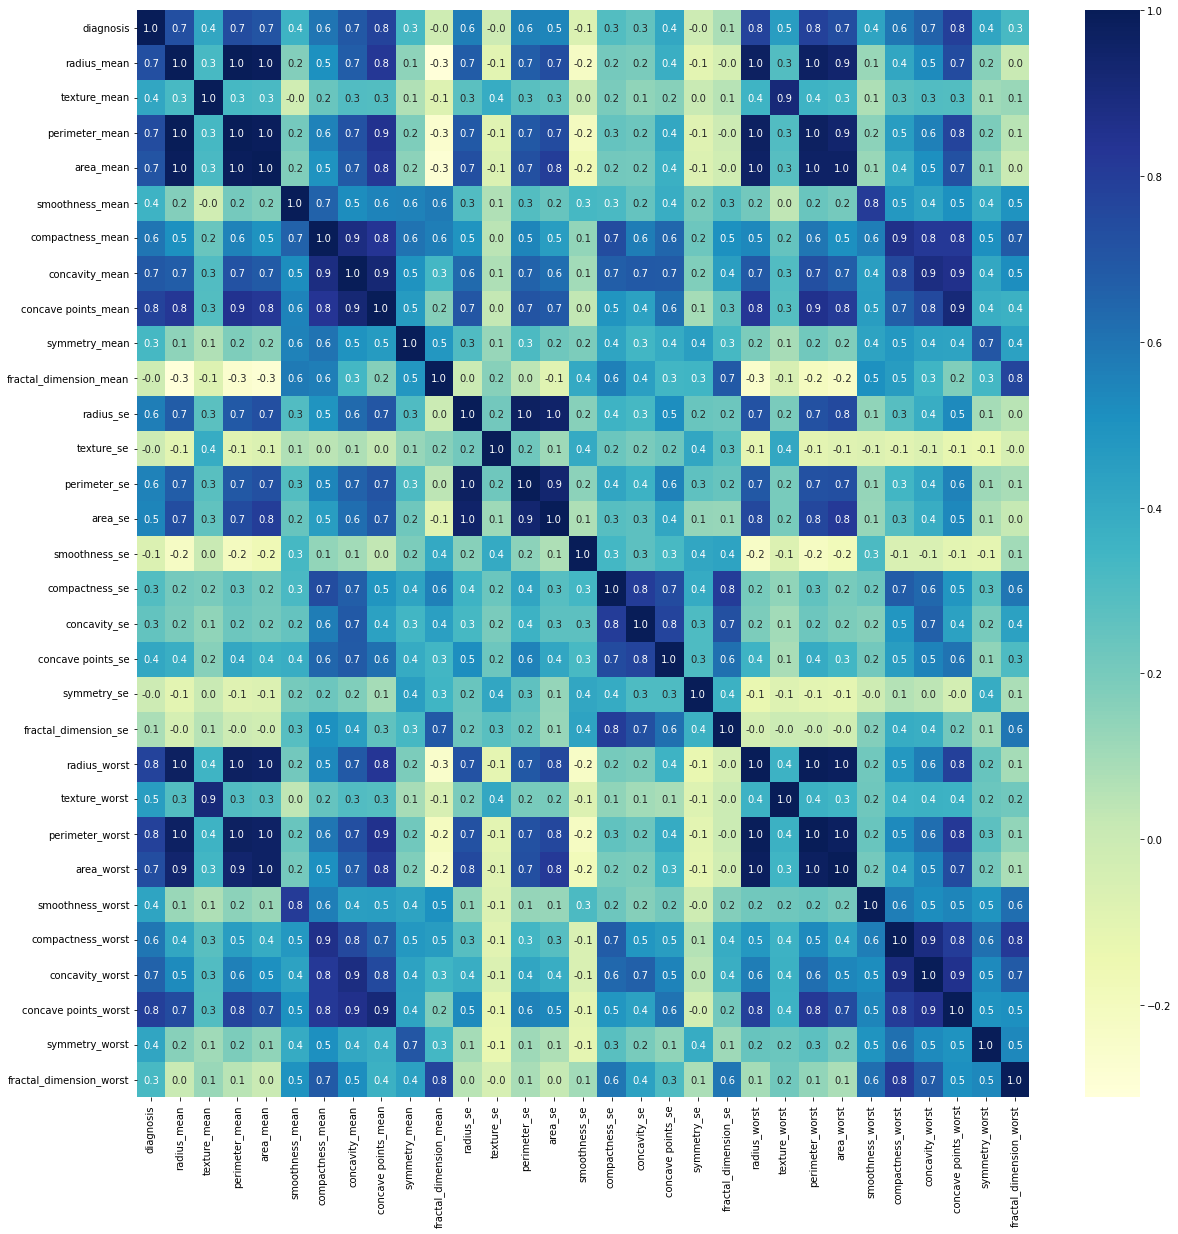

In [11]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(df_clean.corr(),annot=True,cmap='YlGnBu',fmt='.1f')
plt.rcParams['figure.facecolor'] = 'white'

## Scale data

### Check the range of every features

In [12]:
ranges=pd.DataFrame({'Column': df_clean.columns,
                     'Min': [df_clean[col].min() for col in df_clean.columns],
                     'Max': [df_clean[col].max() for col in df_clean.columns]})

In [13]:
ranges

,Column,Min,Max
0,diagnosis,0.000000,1.00000
1,radius_mean,6.981000,28.11000
2,texture_mean,9.710000,39.28000
3,perimeter_mean,43.790000,188.50000
4,area_mean,143.500000,2501.00000
5,smoothness_mean,0.052630,0.16340
6,compactness_mean,0.019380,0.34540
7,concavity_mean,0.000000,0.42680
8,concave points_mean,0.000000,0.20120
9,symmetry_mean,0.106000,0.30400


### Some columns have large ranges and not all the columns stay at the same level. So the dataset need to be scaled.

In [14]:
scaler=MinMaxScaler()
df_scaled=pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

In [15]:
df_scaled.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,1.0,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,1.0,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,1.0,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,1.0,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


## Split the dataset (70% training vs 30% test)

In [16]:
X=df_scaled.iloc[:,1:].values
y=df_scaled.iloc[:,0].values

In [17]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

# Build Models

In [18]:
lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

# Review the models' performance with accuracy and cross validation score

In [19]:
def model_performance(model):
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    accuracy=accuracy_score(y_test,prediction)
    
    sk_folders=StratifiedKFold(n_splits=5)
    cv_scores=cross_val_score(model, X, y, cv=sk_folders).mean()
    return accuracy,cv_scores

In [20]:
performances_70_30=pd.DataFrame()
performances_70_30['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_70_30['Accuracy_70_30']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_70_30['Average CV Scores_70_30']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

In [21]:
performances_70_30

,Model,Accuracy_70_30,Average CV Scores_70_30
0,Logistic Regression,0.976608,0.963096
1,Decision Tree,0.923977,0.919127
2,Random Forest,0.970760,0.959587
3,KNN,0.964912,0.966620
4,Gaussian Naive Bayes,0.935673,0.927930


# Do the same thing with splitting dataset as 60% training and 40% test

In [22]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.4, random_state=42)

lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

performances_60_40=pd.DataFrame()
performances_60_40['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_60_40['Accuracy_60_40']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_60_40['Average CV Scores_60_40']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

performances_60_40

,Model,Accuracy_60_40,Average CV Scores_60_40
0,Logistic Regression,0.969298,0.963096
1,Decision Tree,0.942982,0.926129
2,Random Forest,0.964912,0.959603
3,KNN,0.964912,0.966620
4,Gaussian Naive Bayes,0.942982,0.927930


In [23]:
performances=performances_70_30.merge(performances_60_40,on='Model')
performances['Accuracy Diff']=performances['Accuracy_70_30']-performances['Accuracy_60_40']
performances['CV Scores Diff']=performances['Average CV Scores_70_30']-performances['Accuracy_60_40']

performances

,Model,Accuracy_70_30,Average CV Scores_70_30,Accuracy_60_40,Average CV Scores_60_40,Accuracy Diff,CV Scores Diff
0,Logistic Regression,0.976608,0.963096,0.969298,0.963096,0.007310,-0.006202
1,Decision Tree,0.923977,0.919127,0.942982,0.926129,-0.019006,-0.023855
2,Random Forest,0.970760,0.959587,0.964912,0.959603,0.005848,-0.005325
3,KNN,0.964912,0.966620,0.964912,0.966620,0.000000,0.001708
4,Gaussian Naive Bayes,0.935673,0.927930,0.942982,0.927930,-0.007310,-0.015052
